In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.stats import *
from jetstream_hugo.data import *
import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
exp = MultiVarExperiment("ERA5", "plev", ["u", "v", "s"], "6H", "all", None, -80, 40, 15, 80, [175, 200, 225, 250, 300, 350])

all_jets_one_df, where_are_jets, all_jets_one_array, all_jets_over_time, flags = exp.track_jets(processes=N_WORKERS, chunksize=100)
props_as_ds_uncat = exp.props_as_ds(False, processes=N_WORKERS, chunksize=100)
ds = exp.ds
da = exp.ds["s"]
time_mask = (ds.time.dt.season=="JJA")
flags = xr.DataArray(flags, coords=dict(time=ds.time.values, jet=np.arange(flags.shape[1])))
props_as_ds_uncat_ = props_as_ds_uncat.where(props_as_ds_uncat["persistence"] > 2)
props_as_ds = categorize_ds_jets(props_as_ds_uncat_)
props_as_ds["nao"] = get_nao(props_as_ds)
props_as_ds['exists'] = (~props_as_ds['mean_lon'].isnull()).astype(np.float32)
props_as_ds_anoms = compute_anomalies_ds(props_as_ds, "hourofyear", True)

exp_T = Experiment(
    "ERA5", "surf", "t", "6H", "all", [5, 6, 7, 8, 9], -30, 40, 30, 75, 250, 'hourofyear', {'hourofyear': ('win', 4 * 15)}, None,
)
da_T = exp_T.da

land_mask = get_land_mask()
lon, lat = da_T.lon.values, da_T.lat.values
mask = land_mask.sel(lon=lon, lat=lat)
da_cee = exp_T.select_heat_wave_cluster(22, 17)

# Visualize clusters

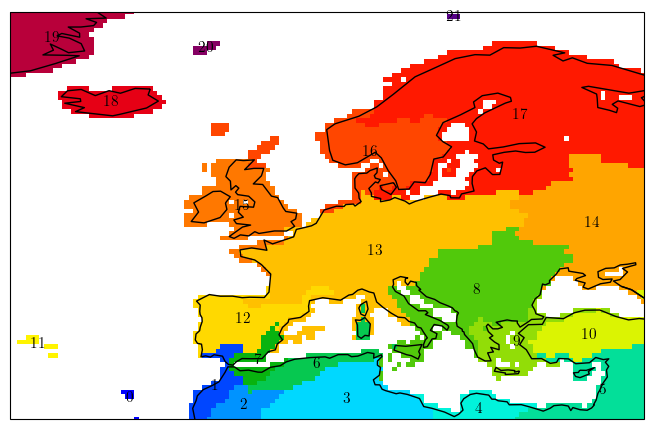

In [17]:
clu = Clusterplot(1, 1, exp_T.region)
Z = exp_T.heat_wave_linkage()
cmap = colormaps.BlAqGrYeOrReVi200
mask = get_land_mask()
lon, lat = da_T.lon.values, da_T.lat.values
mask = mask.sel(lon=lon, lat=lat)
stack_dims = {'lat_lon': ('lat', 'lon')}
mask_flat = mask.stack(stack_dims)
for i, n_clu in enumerate(range(22, 23)):
    ax = clu.axes[i]
    clusters = cut_tree(Z, n_clusters=n_clu)[:, 0]
    clusters_da = np.zeros(mask_flat.shape, dtype=float)
    clusters_da[:] = np.nan
    clusters_da = mask_flat.copy(data=clusters_da)
    clusters_da[mask_flat] = clusters
    unique_clusters = np.unique(clusters)
    norm = BoundaryNorm(np.concatenate([[-1], unique_clusters]) + 0.5, cmap.N)
    every = n_clu // 20 + 1
    clusters_da.unstack().plot(
        ax=ax,
        cmap=cmap,
        add_colorbar=False,
        add_labels=False
    )
    for j in range(n_clu):
        lo = clusters_da.lon.where(clusters_da==j).mean().item()
        la = clusters_da.lat.where(clusters_da==j).mean().item()
        ax.text(lo, la, f"${j}$", ha="center", va="center", fontweight="bold")
    # ax.set_title(n_clu)
    # im = ScalarMappable(cmap=cmap, norm=norm)
    # clu.fig.colorbar(im, ax=ax, ticks=np.arange(0, n_clu, every), shrink=0.92, pad=0.01)

# Correlation of drivers

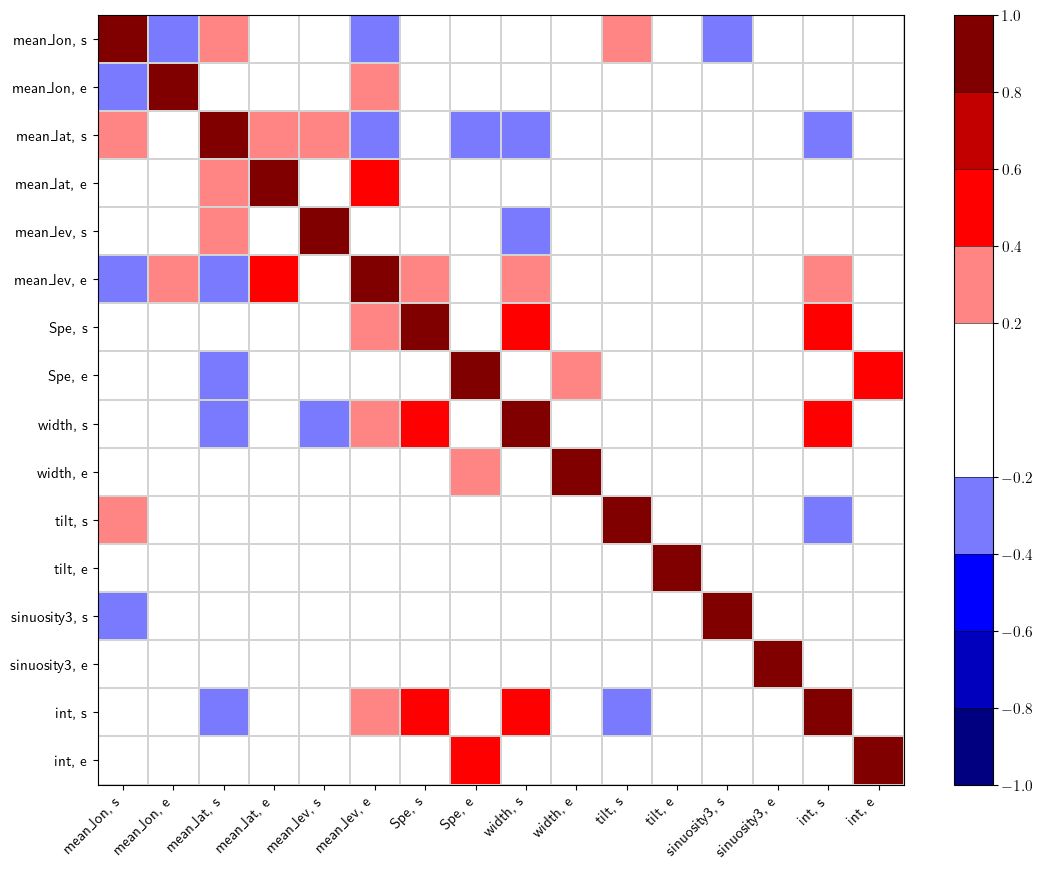

In [3]:
subset = ["mean_lon", "mean_lat", "mean_lev", "Spe", "width", "tilt", "sinuosity3", "int"]
props_as_ds_late = props_as_ds[subset].sel(time=da_cee.time.values)
cmap = colormaps.BlWhRe
norm = BoundaryNorm(np.delete(np.arange(-1, 1.1, 0.2), 5), cmap.N)
to_concat = []
ticks = []
valids = props_as_ds_late["mean_lon"]
valids = (
    ~valids.sel(jet="polar").isnull() & ~valids.sel(jet="subtropical").isnull()
).values
for varname, da in props_as_ds_late.items():
    if varname not in [
        "anti_pv_activity",
        "cycl_pv_activity",
        "overlap",
        "vert_dist",
        "n_jets",
        "nao",
    ]:
        for jet in da.jet.values:
            to_concat.append(da.sel(jet=jet).values[valids])
            ticks.append(f"{varname}, {SHORTHAND[jet][0]}")
    else:
        to_concat.append(np.roll(da.values[valids], 0))
        ticks.append(varname)
fig, ax = plt.subplots(figsize=(13, 10))
im = plt.pcolormesh(np.corrcoef(np.stack(to_concat)), cmap=cmap, norm=norm, lw=0.01, edgecolors="lightgrey")
plt.colorbar(im, spacing="proportional", drawedges=True)
ax.invert_yaxis()
ax.set_yticks(np.arange(0.5, len(ticks) + 0.5), ticks)
_ = ax.set_xticks(np.arange(0.5, len(ticks) + 0.5), ticks, rotation=45, ha="right")
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_corr_subset.png")

# Create drivers and targets

In [3]:
subset = ["mean_lon", "mean_lat", "mean_lev", "Spe", "width", "tilt", "sinuosity3", "int"]

timescales = [0, 3, 7, 15]
timescales = [timescale * 4 + int(timescale == 0) for timescale in timescales]
lags = [0, 4, 7]
lags = [lag * 4 for lag in lags]

props_as_ds_late = props_as_ds[subset].sel(time=da_cee.time.values)
props_as_ds_detrended = props_as_ds_late.copy()
for varname in subset:
    props_as_ds_late[varname] = props_as_ds_late[varname].fillna(DEFAULT_VALUES[varname])    
    props_as_ds_detrended[varname] = xrft.detrend(props_as_ds_late[varname], dim='time', detrend_type='linear')
props_as_da_late = props_as_ds_late.to_array(dim='varname', name='predictors')
props_as_da_detrended = props_as_ds_detrended.to_array(dim='varname', name='predictors')
props_as_da_late = props_as_da_late.expand_dims(axis=-1, **dict(timescale=timescales)).copy(deep=True)
props_as_da_detrended = props_as_da_detrended.expand_dims(axis=-1, **dict(timescale=timescales)).copy(deep=True)
da_cee = exp_T.select_heat_wave_cluster(22, 17)
da_cee = da_cee.expand_dims(axis=1, **dict(timescale=timescales)).copy(deep=True)
da_T_detrended = xrft.detrend(da_T, dim='time', detrend_type='linear').expand_dims(axis=1, **dict(timescale=timescales)).copy(deep=True)

for n_timestep in tqdm(timescales[1:]):
    for year in np.unique(da_cee.time.dt.year):
        year_mask = da_cee.time.dt.year == year
        da_cee.loc[year_mask, n_timestep] = da_cee.loc[year_mask, 1].rolling(time=n_timestep, center=False).mean().shift(time=-n_timestep + 1)
        da_T_detrended.loc[year_mask, n_timestep, ...] = da_T_detrended.loc[year_mask, 1, ...].rolling(time=n_timestep, center=False).mean().shift(time=-n_timestep + 1)
        props_as_da_late.loc[:, year_mask, :, n_timestep] = props_as_da_late.loc[:, year_mask, :, n_timestep].rolling(time=n_timestep, center=False).mean()
        props_as_da_detrended.loc[:, year_mask, :, n_timestep] = props_as_da_detrended.loc[:, year_mask, :, n_timestep].rolling(time=n_timestep, center=False).mean()

100%|██████████| 3/3 [00:38<00:00, 12.84s/it]


# Find response regions to jet indices

In [34]:
def stacked_lstsq(L, b, rcond=1e-10): # https://stackoverflow.com/questions/30442377/how-to-solve-many-overdetermined-systems-of-linear-equations-using-vectorized-co
    """
    Solve L x = b, via SVD least squares cutting of small singular values
    L is an array of shape (..., M, N) and b of shape (..., M).
    Returns x of shape (..., N)
    """
    u, s, v = np.linalg.svd(L, full_matrices=False)
    s_max = s.max(axis=-1, keepdims=True)
    s_min = rcond*s_max
    inv_s = np.zeros_like(s)
    inv_s[s >= s_min] = 1/s[s>=s_min]
    x = np.einsum('...ji,...j->...i', v, inv_s * np.einsum('...ji,...j->...i', u, b.conj()))
    return np.conj(x, x)


def create_all_triplets(props_as_da, response_da):
    triplets = []
    for varname in props_as_da.varname.values:
        for jet, n_timestep, lag in product(props_as_da.jet.values, timescales, lags):
            try:
                driver = props_as_da.loc[varname, :, jet, n_timestep]
            except IndexError:
                driver = props_as_ds.loc[varname, :, n_timestep]
            response = response_da.loc[:, n_timestep, :, :]
            triplets.append(((varname, jet, n_timestep, lag), driver, response))
    return triplets


def compute_r(triplet):
    (varname, jet, n_timestep, lag), driver_, response_ = triplet
    drivers, responses = [], []
    for year in YEARS:
        slice_ = slice(pd.Timestamp(year, 6, 1), pd.Timestamp(year, 9, 1))
        driver = driver_.loc[slice_].values
        response = response_.loc[slice_].values
        response = response.reshape(response.shape[0], -1)
        response_resid = stacked_lstsq(response[n_timestep:, None], response[:-n_timestep])
        response[:-n_timestep] = response[:-n_timestep] - response[n_timestep:] * response_resid
        response = response.reshape(response.shape[0], *da_T_detrended.shape[-2:])
        driver_resid = np.linalg.lstsq(driver[n_timestep:, None], driver[:-n_timestep], rcond=None)[0][0]
        driver[:-n_timestep] = driver[:-n_timestep] - driver[n_timestep:] * driver_resid
        driver = np.nan_to_num(driver, DEFAULT_VALUES[varname])
        if lag > 0:
            driver = driver[lag:]
            response = response[:-lag]
        drivers.append(driver)
        responses.append(response)
    driver = np.concatenate(drivers, axis=0)
    response = np.concatenate(responses, axis=0)
    r = np.sum(driver[:, None, None] * response, axis=0) / np.sqrt(np.sum(driver[:, None, None] ** 2, axis=0) * np.sum(response ** 2, axis=0))
    return r

try:
    corr_da = xr.open_dataarray('/storage/homefs/hb22g102/persistent-extremes-era5/results/vanstraaten/corr_da.nc')
except FileNotFoundError:
    coords = {
        'varname': props_as_da_detrended.varname.values,
        'jet': props_as_da_detrended.jet.values,
        'timescale': timescales,
        'lag': lags,
        'lat': da_T_detrended.lat.values,
        'lon': da_T_detrended.lon.values,
    }
    corr_da = xr.DataArray(np.zeros([len(c) for c in coords.values()]), coords=coords)
    corr_da.assign_coords(pstar=('timescale', 5 * 10 ** (-2 - 0.3 * (corr_da.timescale.values - 1))))
    triplets = create_all_triplets(props_as_da_detrended, da_T_detrended)
    with Pool(processes=N_WORKERS) as pool:
        all_r = list(tqdm(pool.imap(compute_r, triplets, chunksize=3), total=len(triplets),))
    # all_r = list(tqdm(map(compute_r, triplets), total=len(triplets)))
    all_r = np.asarray(all_r)
    triplet_params = np.asarray([triplet[0] for triplet in triplets])
    newshape = [len(np.unique(triplet_param)) for triplet_param in triplet_params.T]
    all_r = all_r.reshape(*newshape, *all_r[0].shape)
    corr_da[:] = all_r
        
    corr_da.to_netcdf('/storage/homefs/hb22g102/persistent-extremes-era5/results/vanstraaten/corr_da.nc')

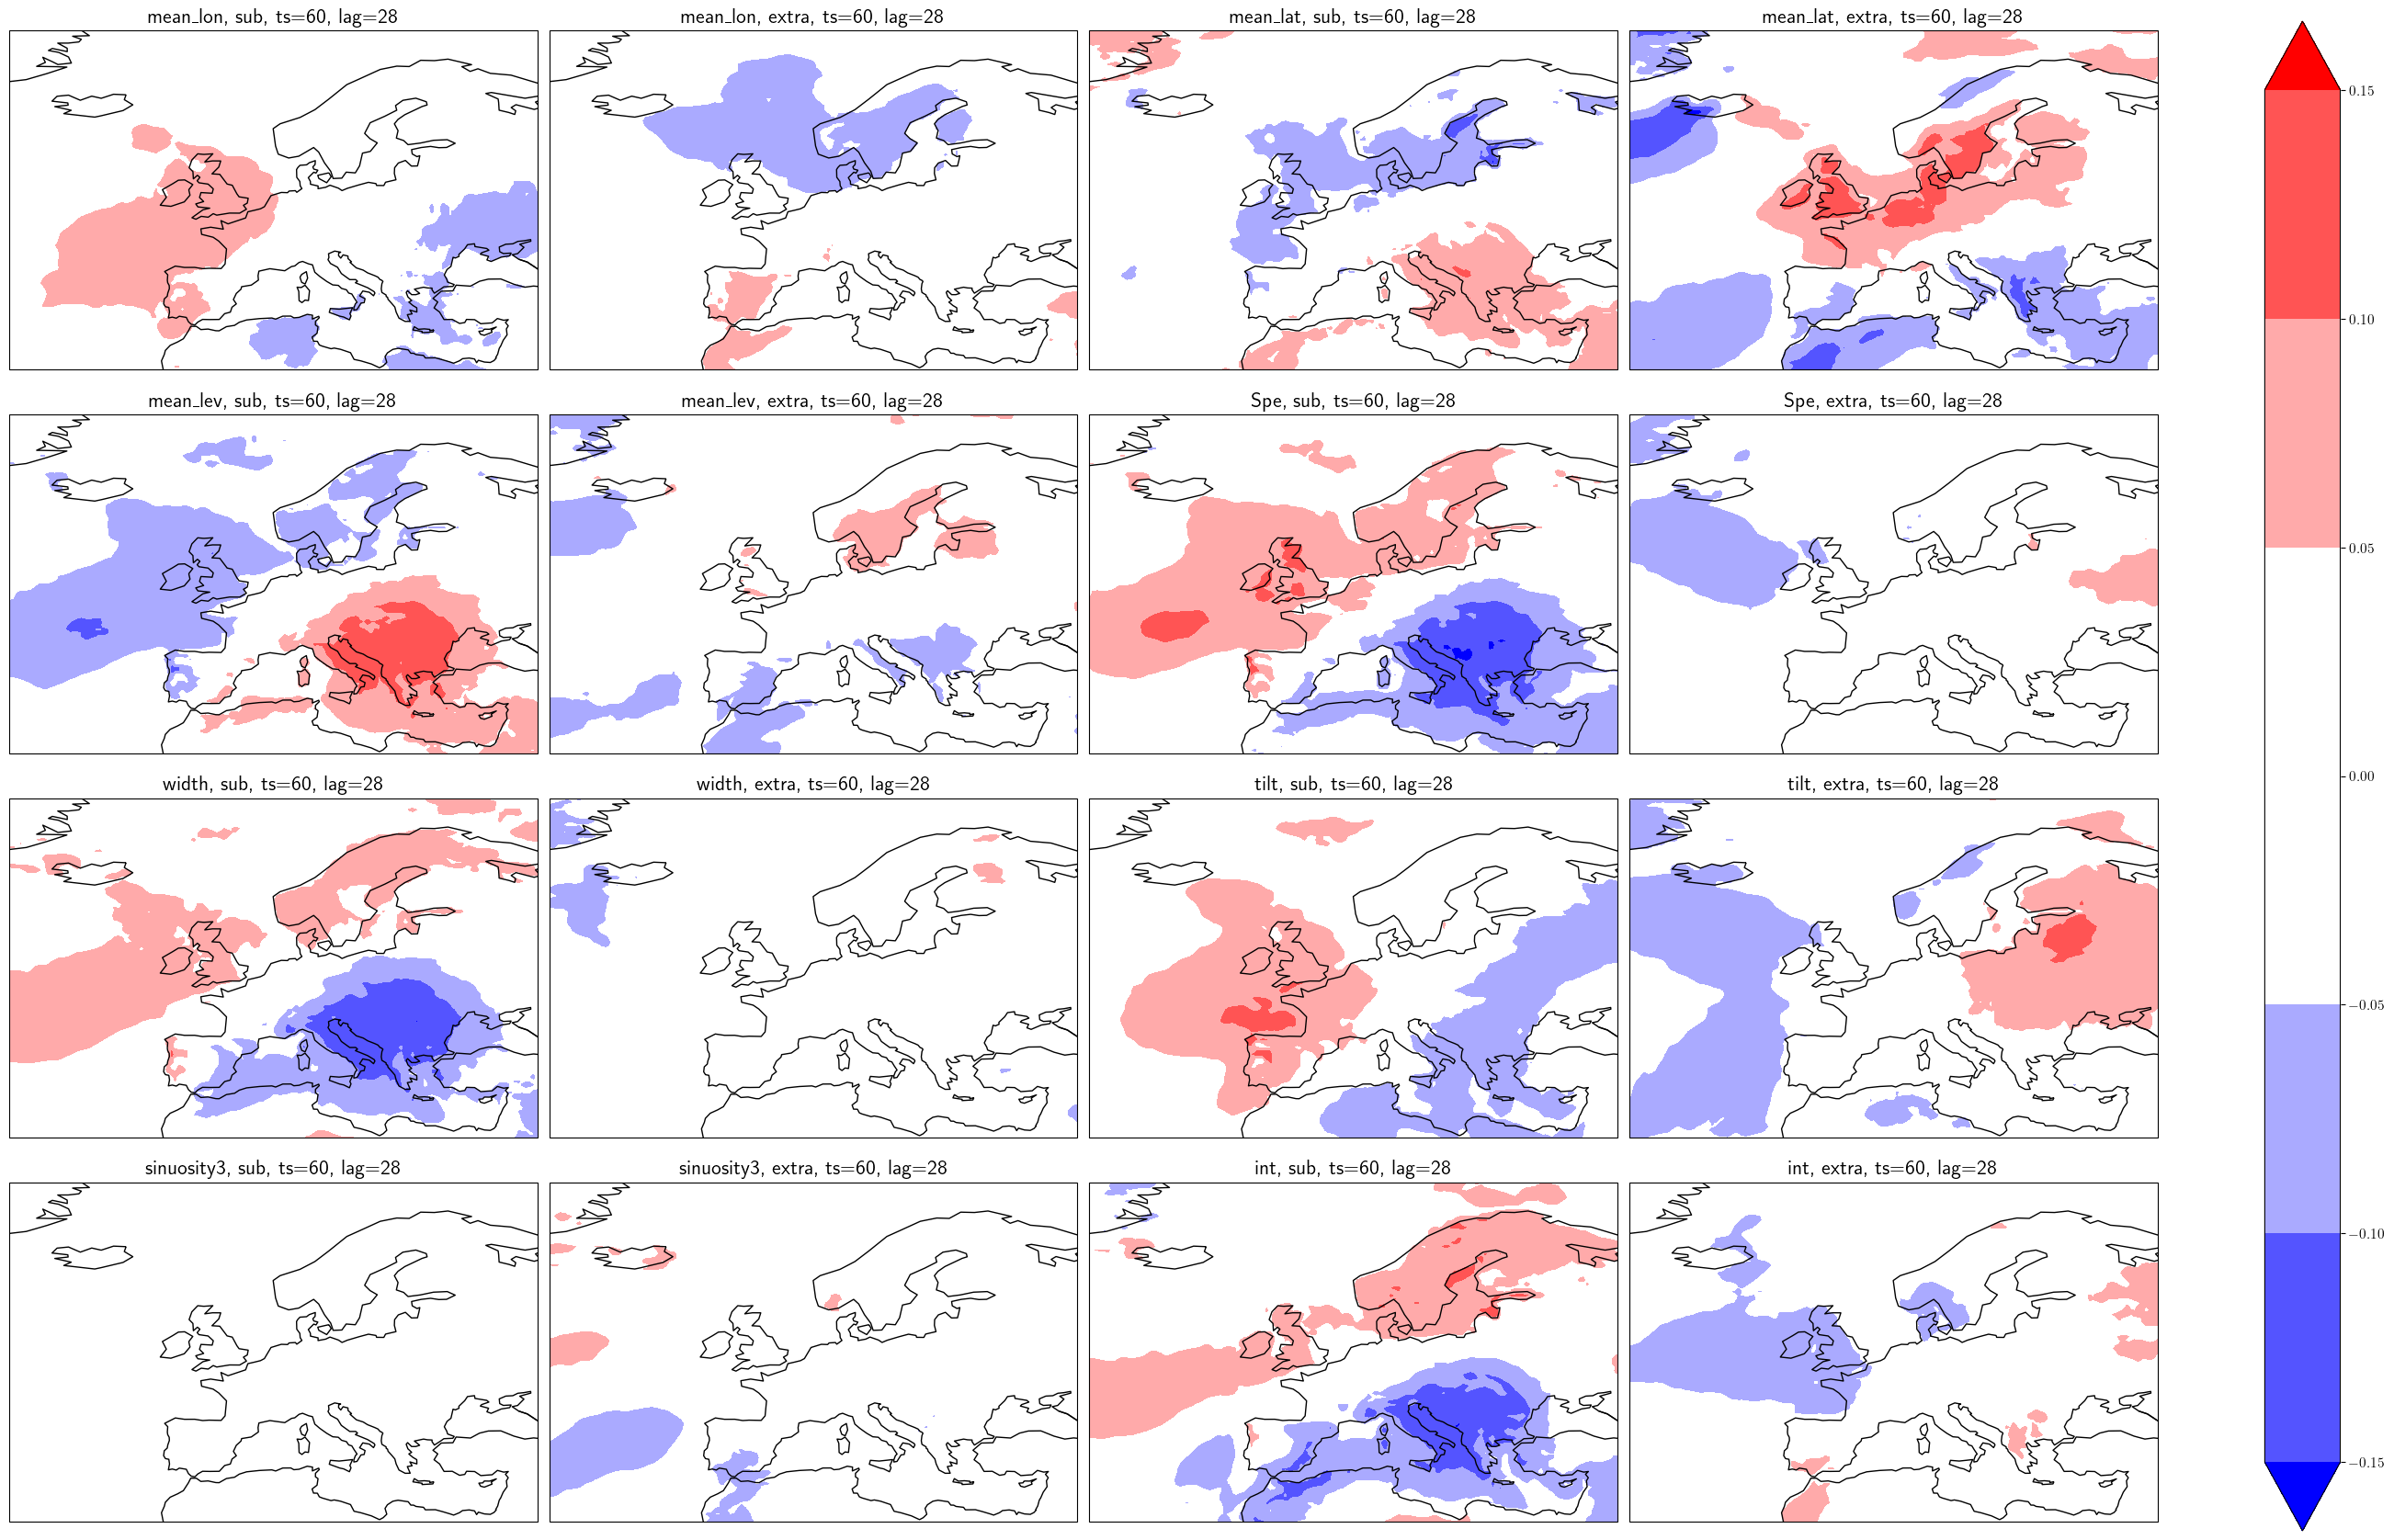

In [48]:
to_plot = []
titles = []
k, l = 3, 2
for i, varname in enumerate(subset):
    for j, jet in enumerate(corr_da.jet.values):
        to_plot.append(corr_da[i, j, k, l])
        titles.append(f"{varname}, {SHORTHAND[jet]}, ts={timescales[k]}, lag={lags[l]}")
        
clu = Clusterplot(4, 4, get_region(corr_da))
_ = clu.add_contourf(to_plot, titles=titles, cmap="bwr", transparify=1)
plt.savefig(f"{FIGURES}/vanstraaten/corr_ts={timescales[k]}_l={lags[l]}.png")

# Prediction task for CEE

In [4]:
from sklearn.metrics import brier_score_loss

da_cee_targets = da_cee > da_cee.quantile(0.66, dim="time")
summer_mask = np.isin(da_cee.time.dt.month.values, [6, 7, 8])
da_cee_targets = da_cee_targets.sel(time=summer_mask, timescale=[12, 28])
base_pred = da_cee_targets.copy(data=np.zeros(da_cee_targets.shape, dtype=float))
base_pred = base_pred.assign_coords(
    f1_score=("timescale", np.zeros(len(base_pred.timescale))),
    roc_score=("timescale", np.zeros(len(base_pred.timescale))),
    accuracy=("timescale", np.zeros(len(base_pred.timescale))),
    brier_score_loss=("timescale", np.zeros(len(base_pred.timescale))),
)
X_base = (
    (da_cee_targets.time.values - da_cee_targets.time.values[0])
    .astype("timedelta64[h]")
    .astype(int)[:, None]
)
for timescale in da_cee_targets.timescale.values:
    y = da_cee_targets.loc[:, timescale].values
    X_train, X_test, y_train, y_test = train_test_split(X_base, y, test_size=0.2)
    lr = LogisticRegression(class_weight=None).fit(X_train, y_train)
    y_pred_prob = lr.predict_proba(X_test)[:, 1]
    y_pred = lr.predict(X_test)
    base_pred.loc[:, timescale] = lr.predict_proba(X_base)[:, 1]
    base_pred.roc_score.loc[timescale] = roc_auc_score(y_test, y_pred_prob)
    base_pred.brier_score_loss.loc[timescale] = brier_score_loss(y_test, y_pred_prob)
    base_pred.f1_score.loc[timescale] = f1_score(y_test, y_pred)
    base_pred.accuracy.loc[timescale] = balanced_accuracy_score(y_test, y_pred)

In [5]:
detrended = True
if detrended:
    props_as_da_lagged = props_as_da_detrended.expand_dims(axis=-1, **dict(lag=lags)).copy(deep=True)
else:
    props_as_da_lagged = props_as_da_late.expand_dims(axis=-1, **dict(lag=lags)).copy(deep=True)
for lag in lags[1:]:
    for year in np.unique(props_as_da_lagged.time.dt.year):
        year_mask = props_as_da_lagged.time.dt.year == year
        props_as_da_lagged.loc[:, year_mask, :, :, lag] = props_as_da_lagged.loc[:, year_mask, :, :, lag].shift(time=lag)
props_as_da_lagged_stacked = props_as_da_lagged.stack(predictor=('varname', 'jet', 'timescale'))
newindex = ['_'.join([str(t) for t in ts]) for ts in props_as_da_lagged_stacked.predictor.values]
props_as_da_lagged_stacked = props_as_da_lagged_stacked.drop_vars(['timescale', 'varname', 'predictor', 'jet']).assign_coords(predictor=newindex)
props_as_da_lagged_stacked = props_as_da_lagged_stacked[summer_mask]

## like Garcia-Burgos

In [6]:
from jetstream_hugo.hotspells import *
from sklearn.metrics import brier_score_loss

_, _, hs_da = heat_waves_from_t(exp_T.select_heat_wave_cluster(22, 17), q=0.66, minlen=np.timedelta64(4, 'D'), fill_holes=True, output_type="both")

In [7]:
targets = hs_da.sel(time=hs_da.time.dt.season=="JJA") > 0
preds = targets.copy().astype(np.float32)
X_base = (
    (targets.time.values - targets.time.values[0])
    .astype("timedelta64[h]")
    .astype(int)[:, None]
)
y = targets.values
X_train, X_test, y_train, y_test = train_test_split(X_base, y, test_size=0.1)
lr = LogisticRegression(class_weight=None).fit(X_train, y_train)
y_pred_prob = lr.predict_proba(X_test)[:, 1]
y_pred = lr.predict(X_test)
preds[:] = lr.predict_proba(X_base)[:, 1]
preds.attrs["roc_score"] = roc_auc_score(y_test, y_pred_prob)
preds.attrs["brier_score_loss"] = brier_score_loss(y_test, y_pred_prob)
preds.attrs["f1_score"] = f1_score(y_test, y_pred)
preds.attrs["accuracy"] = balanced_accuracy_score(y_test, y_pred)

## with randomforest

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap

targets = da_cee_targets - base_pred
full_pred = (
    da_cee_targets.expand_dims(axis=-1, **dict(lag=lags)).copy(deep=True).astype(float)
)
full_pred[:] = 0
full_pred = full_pred.assign_coords(
    f1_score=(("timescale", "lag"), np.zeros(full_pred.shape[1:])),
    roc_score=(("timescale", "lag"), np.zeros(full_pred.shape[1:])),
    accuracy=(("timescale", "lag"), np.zeros(full_pred.shape[1:])),
    brier_score_loss=(("timescale", "lag"), np.zeros(full_pred.shape[1:])),
)
coords = {
    "varname": props_as_da_lagged.varname.values,
    "jet": props_as_da_lagged.jet.values,
    "driver_timescale": props_as_da_lagged.timescale.values,
    "target_timescale": full_pred.timescale.values,
    "lag": full_pred.lag.values,
}
permutation_importances = xr.DataArray(
    np.zeros([len(c) for c in coords.values()]), coords=coords
)
shap_importances = {}
for timescale, lag in tqdm(
    product(targets.timescale.values, lags),
    total=len(targets.timescale.values) * len(lags),
):
    if timescale not in shap_importances:
        shap_importances[timescale] = {}
    # timescale of target, lag of driver
    y_orig = da_cee_targets.loc[:, timescale].to_pandas()
    y = targets.loc[:, timescale].to_pandas()
    X = props_as_da_lagged_stacked.sel(lag=lag).to_pandas()
    X_train, X_test, y_train, y_test, _, y_orig_test, _, idx_test = train_test_split(
        X, y, y_orig, np.arange(base_pred.shape[0]), test_size=0.2
    )
    rfr = RandomForestRegressor(
        max_depth=5,
        n_estimators=2500,
        min_samples_split=30,
        max_features=35,
        n_jobs=N_WORKERS,
    ).fit(X_train, y_train) # van straaten parameters
    y_pred_prob = rfr.predict(X_test) + base_pred.loc[:, timescale].values[idx_test]
    y_pred_prob = np.clip(y_pred_prob, 0, 1)
    y_pred = y_pred_prob > 0.5
    full_pred.loc[:, timescale, lag] = rfr.predict(X) + base_pred.loc[:, timescale]
    full_pred.roc_score.loc[timescale, lag] = roc_auc_score(y_orig_test, y_pred_prob)
    full_pred.brier_score_loss.loc[timescale, lag] = brier_score_loss(
        y_orig_test, y_pred_prob
    )
    full_pred.f1_score.loc[timescale, lag] = f1_score(y_orig_test, y_pred)
    full_pred.accuracy.loc[timescale, lag] = balanced_accuracy_score(
        y_orig_test, y_pred
    )
    r = permutation_importance(
        rfr, X_test, y_test, n_repeats=30, random_state=0, n_jobs=N_WORKERS
    )
    r = r.importances_mean.reshape(permutation_importances.shape[:3])
    permutation_importances.loc[:, :, :, timescale, lag] = r
    X = pd.DataFrame(
        X,
        index=props_as_da_lagged_stacked.time.values,
        columns=props_as_da_lagged_stacked.predictor.values,
    )
    shap_values = shap.TreeExplainer(rfr)(X, check_additivity=False)
    shap_importances[timescale][lag] = shap_values

/storage/homefs/hb22g102/miniforge3/envs/env11_2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 6/6 [24:08<00:00, 241.41s/it]


In [42]:
shap_abs_mean_importances = permutation_importances.copy()
shap_mean_importances = permutation_importances.copy()
shap_correlations = permutation_importances.copy()
for timescale, lag in product(targets.timescale.values, lags):
    shap_values = shap_importances[timescale][lag]
    shap_abs_mean = shap_values.abs.mean(axis=0).values
    shap_abs_mean_importances.loc[:, :, :, timescale, lag] = shap_abs_mean.reshape(shap_abs_mean_importances.shape[:3])
    shap_mean = shap_values.mean(axis=0).values
    shap_mean_importances.loc[:, :, :, timescale, lag] = shap_mean.reshape(shap_mean_importances.shape[:3])
    importance_correlation = np.diag(np.corrcoef(shap_values.values, shap_values.data, rowvar=False)[shap_values.shape[1]:, :shap_values.shape[1]])
    shap_correlations.loc[:, :, :, timescale, lag] = importance_correlation.reshape(shap_correlations.shape[:3])

In [ ]:
subfolder = "detrended" if detrended else "base"
folder = f'/storage/homefs/hb22g102/persistent-extremes-era5/results/vanstraaten/{subfolder}'
full_pred.to_netcdf(f'{folder}/full_pred.nc')
permutation_importances.to_netcdf(f'{folder}/permutation_importances.nc')
save_pickle(shap_importances, f'{folder}/shap_importances.pkl')
shap_abs_mean_importances.to_netcdf(f'{folder}/shap_abs_mean_importances.nc')
shap_mean_importances.to_netcdf(f'{folder}/shap_mean_importances.nc')
shap_correlations.to_netcdf(f'{folder}/shap_correlations.nc')

## plot results

In [79]:
subfolder = "detrended" if detrended else "base"
folder = f'/storage/homefs/hb22g102/persistent-extremes-era5/results/vanstraaten/{subfolder}'
full_pred = xr.open_dataarray(f'{folder}/full_pred.nc')
permutation_importances = xr.open_dataarray(f'{folder}/permutation_importances.nc')
shap_mean_importances = xr.open_dataarray(f'{folder}/shap_mean_importances.nc')
shap_abs_mean_importances = xr.open_dataarray(f'{folder}/shap_abs_mean_importances.nc')
shap_correlations = xr.open_dataarray(f'{folder}/shap_correlations.nc')


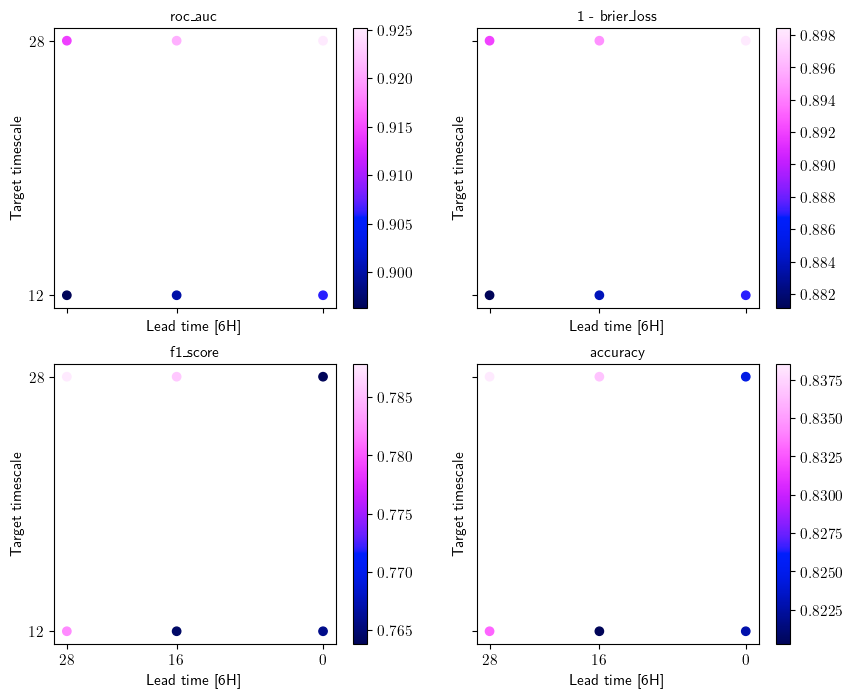

In [45]:
x = full_pred.lag.values
y = full_pred.timescale.values
s = {
    "roc_auc": full_pred.roc_score.values,
    "1 - brier_loss": 1 - full_pred.brier_score_loss.values,
    "f1_score": full_pred.f1_score.values,
    "accuracy": full_pred.accuracy.values,
}
cmap = colormaps.cet_l_bmw1
fig, axes = plt.subplots(2, len(s) // 2, figsize=(10, 8), sharex="all", sharey="all")
for (scorename, s_), ax in zip(s.items(), axes.ravel()):
    im = ax.scatter(*np.meshgrid(x, y), c=s_.ravel(), cmap=cmap)
    ax.set_title(scorename)
    ax.set_xlabel("Lead time [6H]")
    ax.set_xticks(np.unique(x))
    _ = ax.set_ylabel("Target timescale")
    _ = ax.set_yticks(np.unique(y))
    fig.colorbar(im, ax=ax)
ax.invert_xaxis()

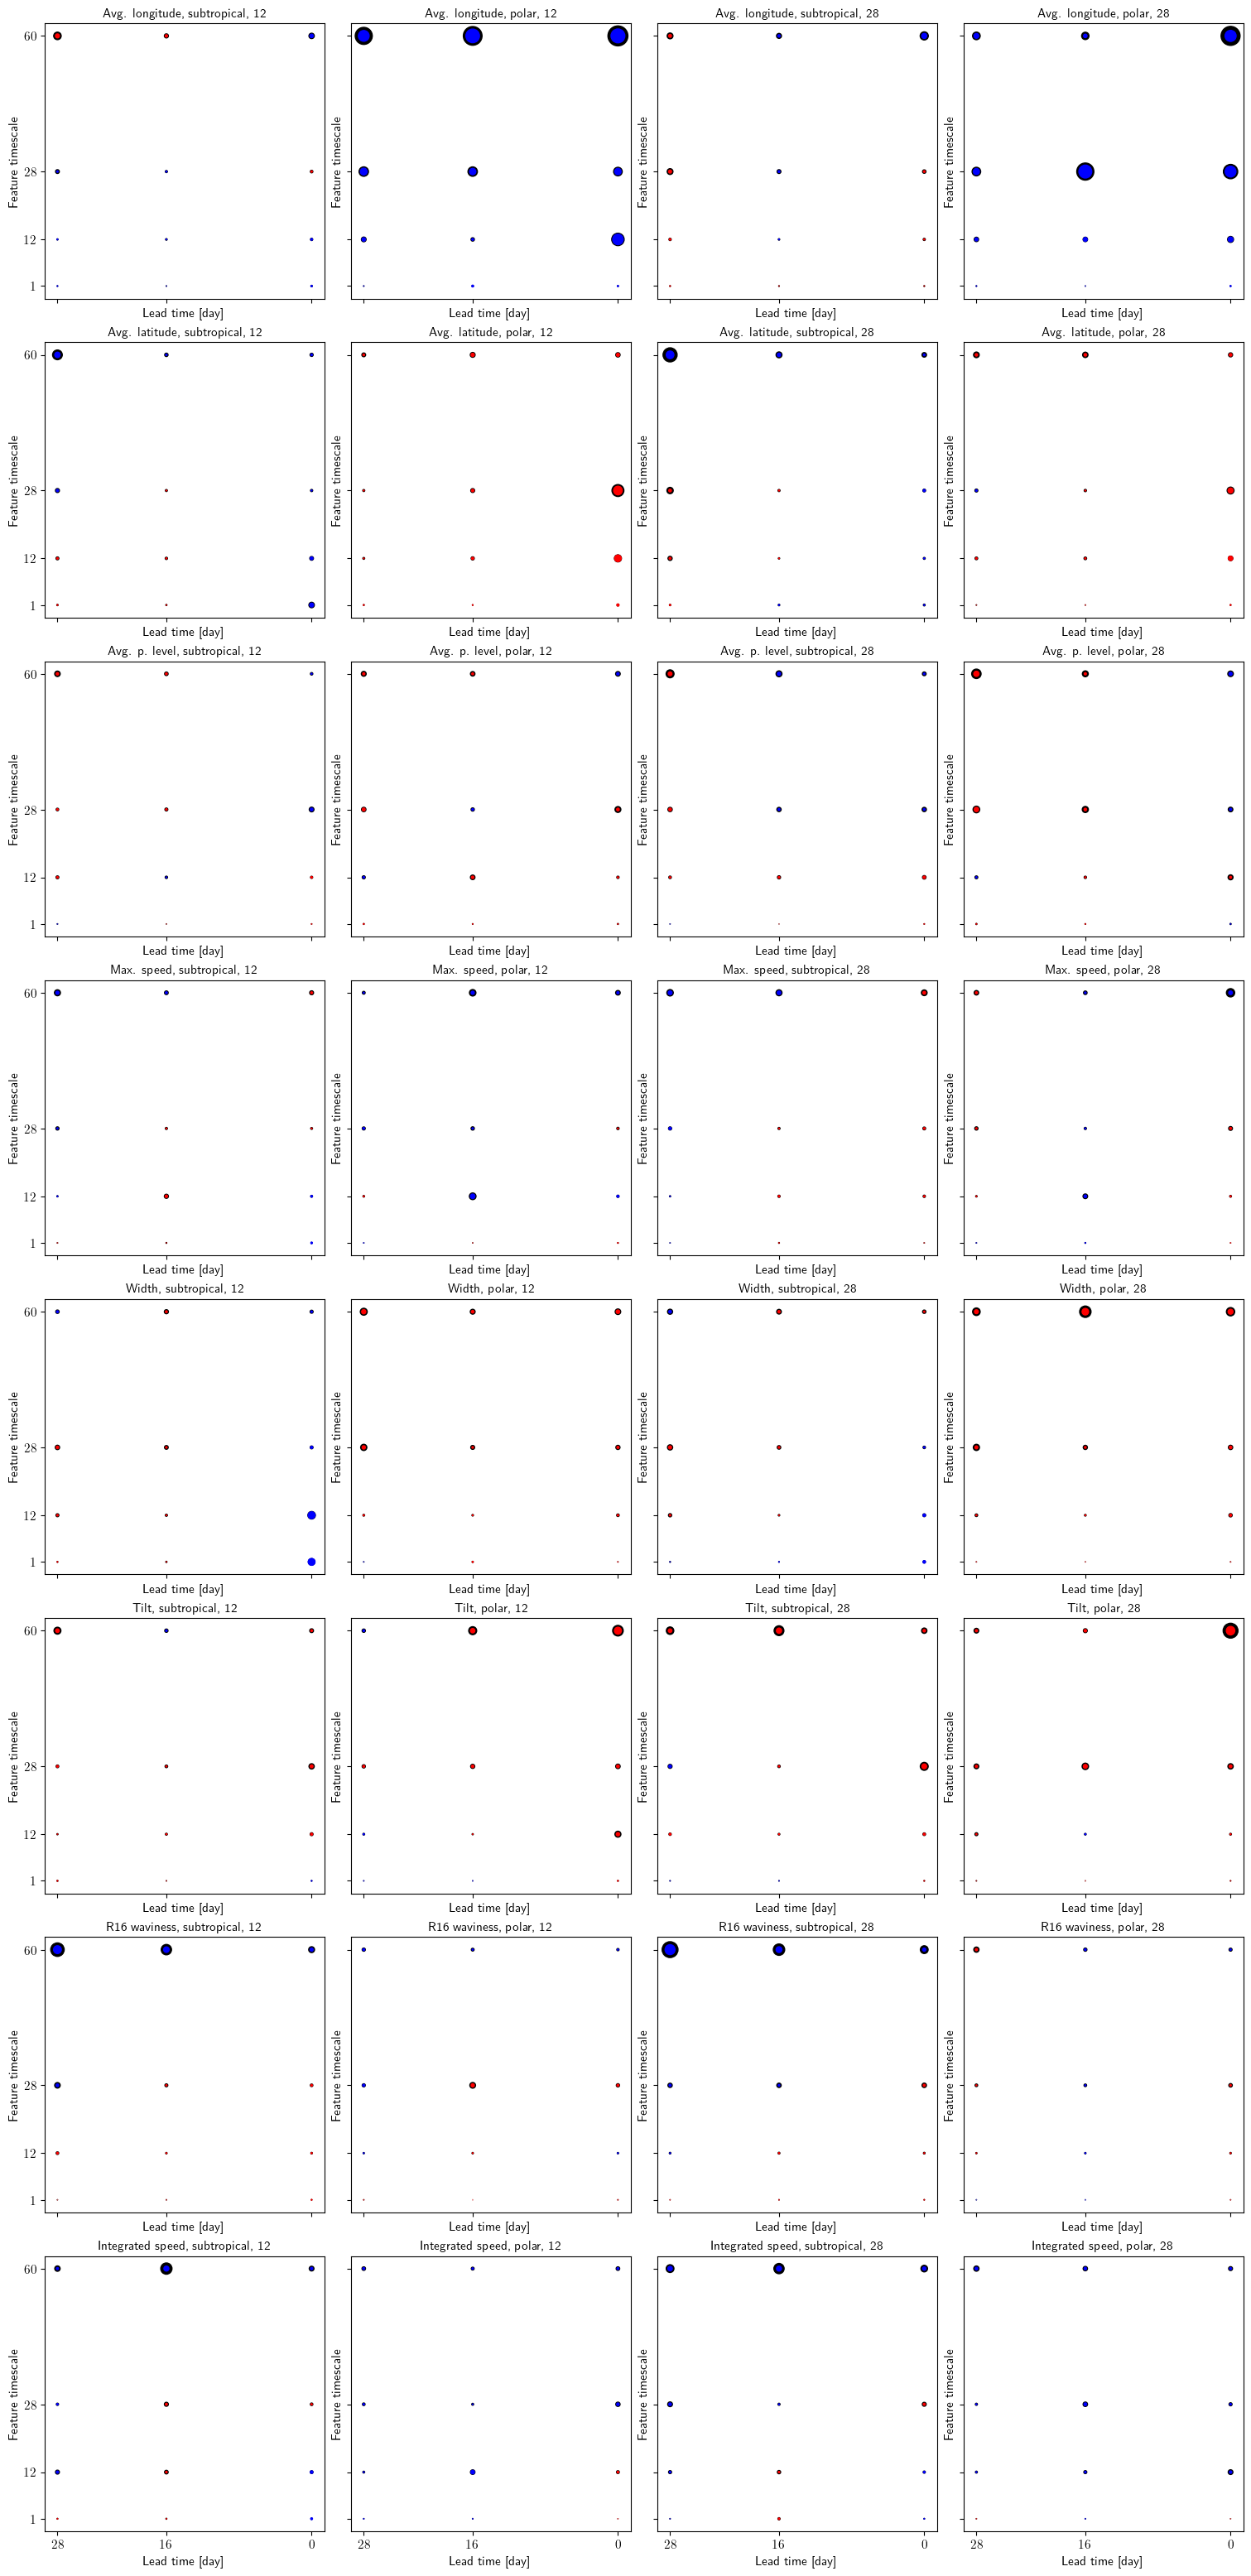

In [15]:
x = shap_abs_mean_importances.lag.values
y = shap_abs_mean_importances.driver_timescale.values
fig, axes = plt.subplots(8, 4, figsize=(15, 31), constrained_layout=True, sharey='all', sharex='all')
target_timescales = [12, 28]
for varname, axs in zip(shap_abs_mean_importances.varname.values, axes):
    for (target_timescale, jet), ax in zip(product(target_timescales, shap_abs_mean_importances.jet.values), axs):
        s1 = permutation_importances.loc[varname, jet, :, target_timescale].values
        s2 = shap_abs_mean_importances.loc[varname, jet, :, target_timescale].values
        s3 = shap_correlations.loc[varname, jet, :, target_timescale].values
        ax.scatter(*np.meshgrid(x, y), s=s1 * 5000, color='black')#, vmin=vmin, vmax=vmax, cmap=colormaps.cet_l_bmw)
        ax.scatter(*np.meshgrid(x, y), s=s2 * 5000, c=np.sign(s3), cmap='bwr', vmin=-1, vmax=1)
        ax.set_xlabel('Lead time [day]')
        ax.set_xticks(np.unique(x))
        ax.set_ylabel('Feature timescale')
        ax.set_yticks(np.unique(y))
        ax.set_title(f'{PRETTIER_VARNAME[varname]}, {jet}, {target_timescale}')
ax.invert_xaxis()

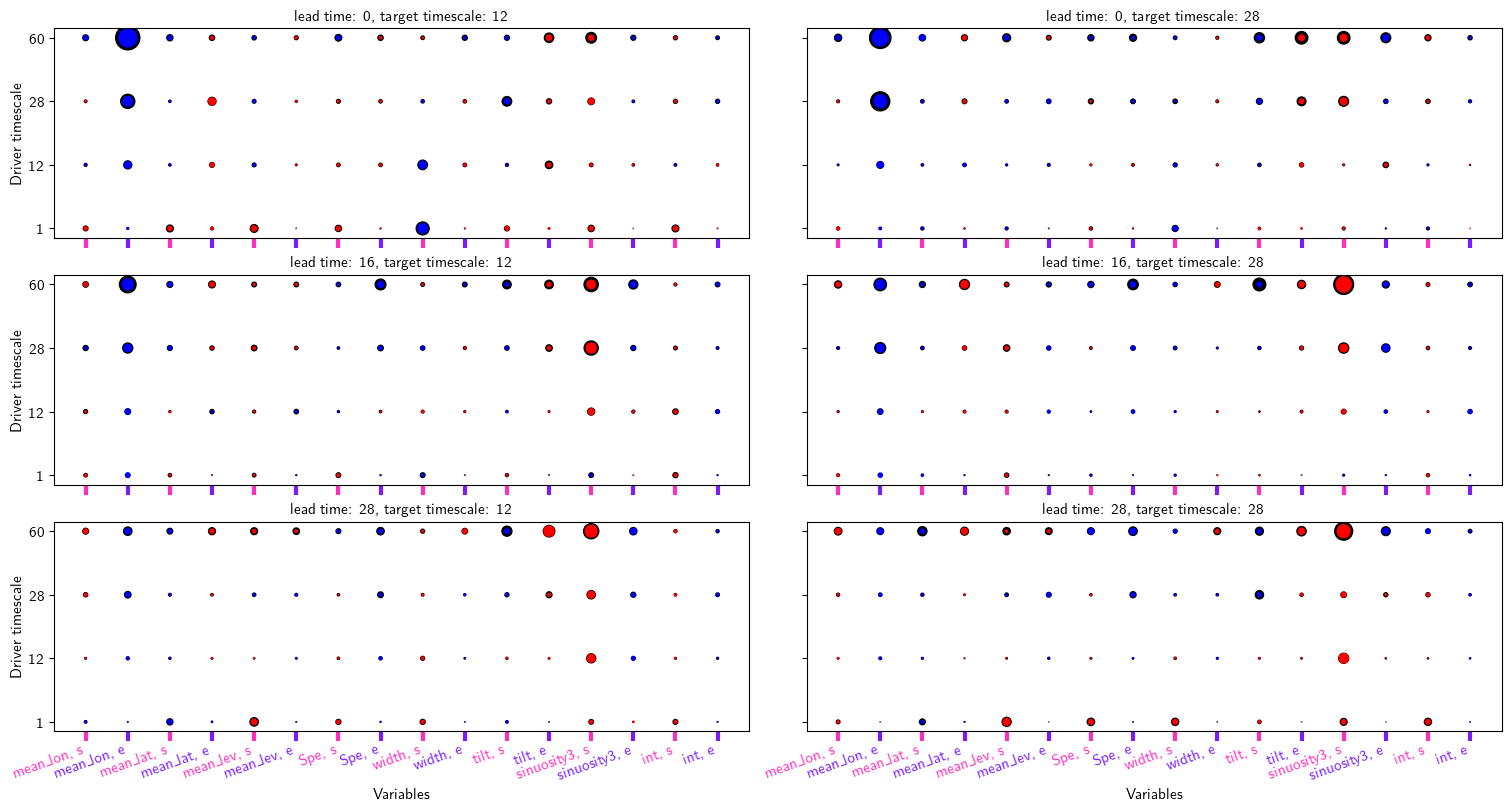

In [75]:
varnames = shap_abs_mean_importances.varname.values
jets = shap_abs_mean_importances.jet.values
lead_times = shap_abs_mean_importances.lag.values
target_timescales = [12, 28]
lead_times = [0, 16, 28]
driver_timescales = shap_abs_mean_importances.driver_timescale.values
fig, axes = plt.subplots(len(lead_times), len(target_timescales), figsize=(15, 8), constrained_layout=True, sharey='all', sharex="all")

for axs, lead_time in zip(axes, lead_times):
    for ax, target_timescale in zip(axs, target_timescales):
        s1 = permutation_importances.loc[:, :, :, target_timescale, lead_time].values.reshape(len(varnames) * len(jets), -1)
        s2 = shap_abs_mean_importances.loc[:, :, :, target_timescale, lead_time].values.reshape(len(varnames) * len(jets), -1)
        c = shap_correlations.loc[:, :, :, target_timescale, lead_time].values.reshape(len(varnames) * len(jets), -1)
        x = np.arange(s1.shape[0])
        y = np.arange(s1.shape[1])
        ax.scatter(*np.meshgrid(x, y), s=s1.T * 5000, color='black')#, vmin=vmin, vmax=vmax, cmap=colormaps.cet_l_bmw)
        ax.scatter(*np.meshgrid(x, y), s=s2.T * 5000, c=np.sign(c).T, cmap='bwr', vmin=-1, vmax=1)
        if lead_time == lead_times[-1]:
            ax.set_xlabel('Variables')
        xticks = ax.set_xticks(np.unique(x), [f"{varname}, {SHORTHAND[jet][0]}" for varname in varnames for jet in jets], rotation=20, ha="right")
        if target_timescale == target_timescales[0]:
            ax.set_ylabel('Driver timescale')
        ax.set_yticks(y, driver_timescales)
        ax.set_title(f'lead time: {lead_time}, target timescale: {target_timescale}')
        ax.tick_params(axis="x", length=7, width=3, pad=1)
        for i, tick in enumerate(xticks):
            tick._apply_params(color=COLORS[1 + (i + 1) % 2], labelcolor=COLORS[1 + (i + 1) % 2])
plt.savefig(f"{FIGURES}/vanstraaten/importance_{subfolder}.png")

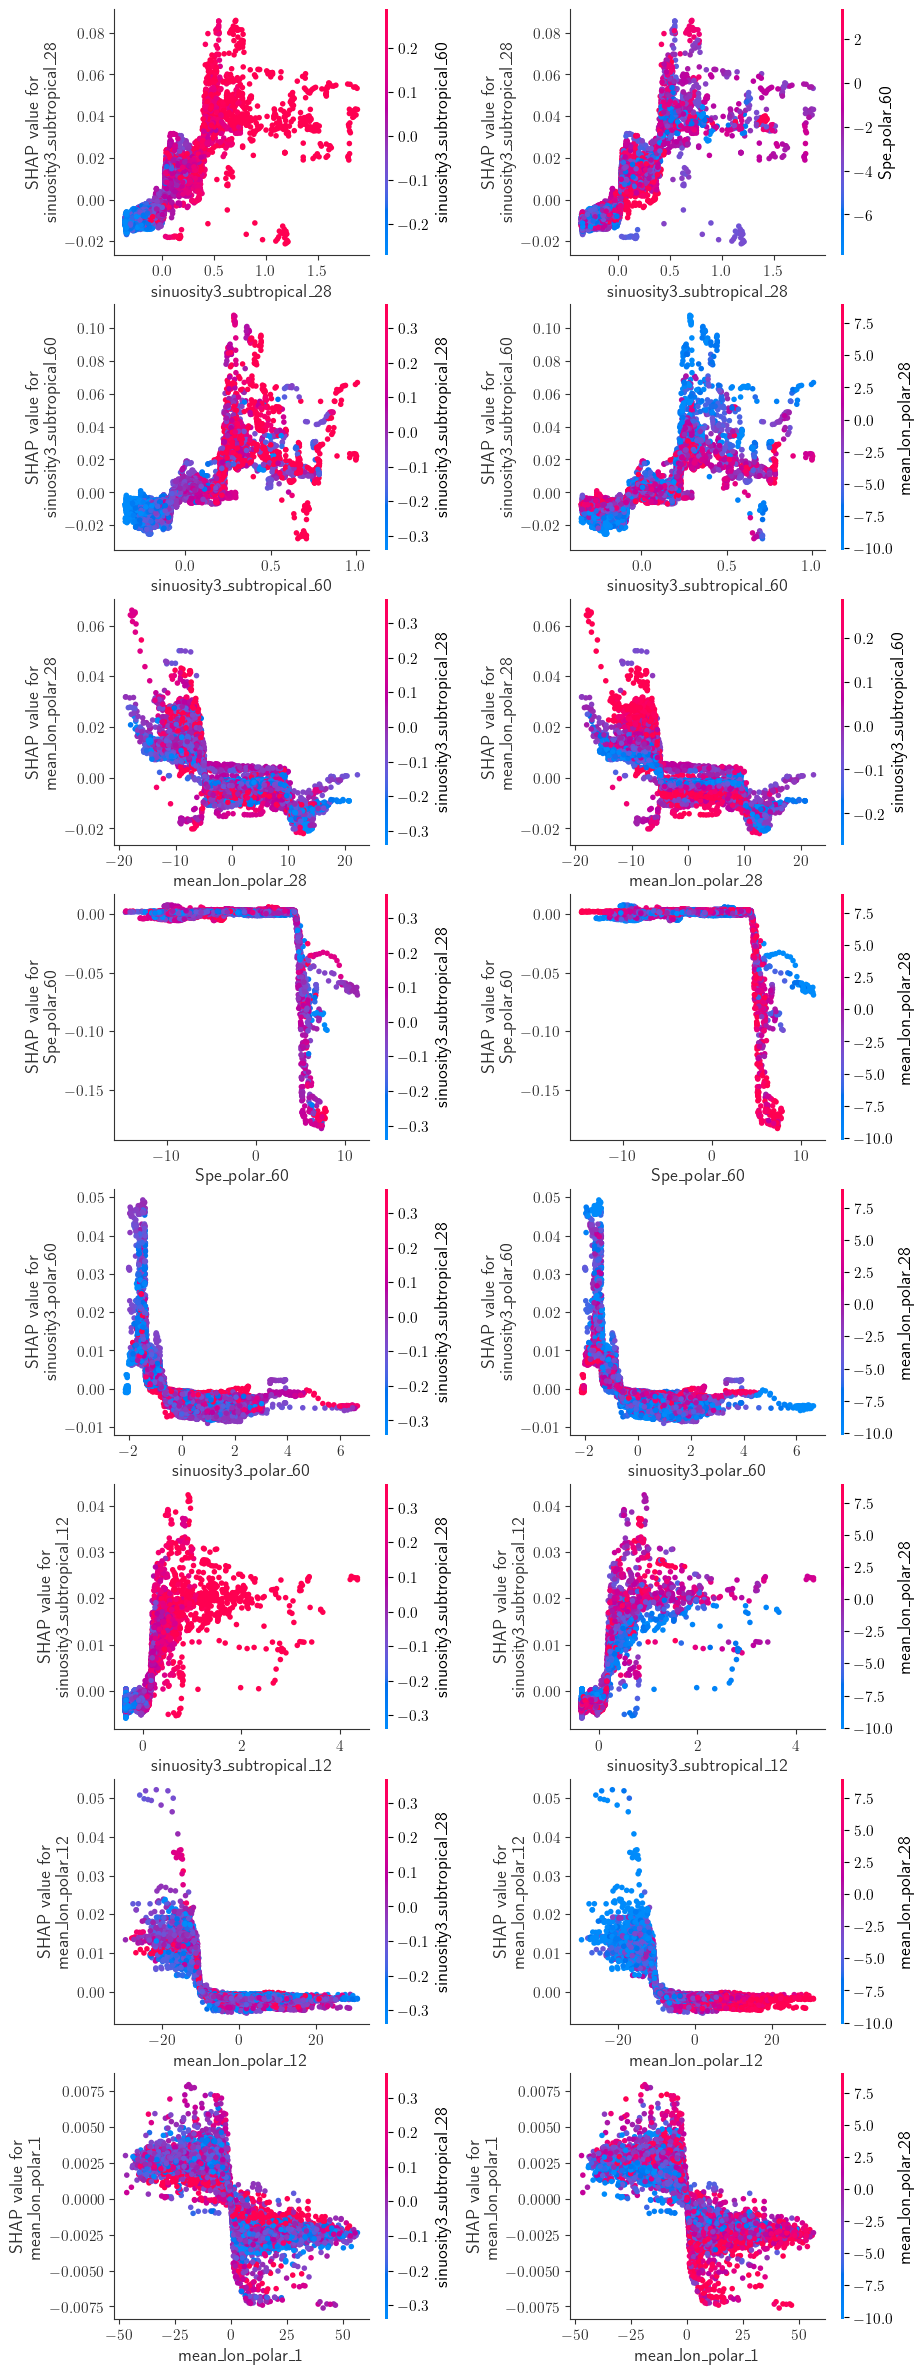

In [87]:
lag = lags[1]
timescale = timescales[1]

y_orig = da_cee_targets.loc[:, timescale].to_pandas()
y = targets.loc[:, timescale].to_pandas()
X = props_as_da_lagged_stacked.sel(lag=lag).to_pandas()
X_train, X_test, y_train, y_test, _, y_orig_test, _, idx_test = train_test_split(
    X, y, y_orig, np.arange(base_pred.shape[0]), test_size=0.2
)  
shap_values = load_pickle(f"{folder}/shap_importances.pkl")
shap_values_ = shap_values[timescale][lag]
fig, axes = plt.subplots(8, 2, figsize=(10, 30), gridspec_kw={"wspace": 0.43})
for axs, rank in zip(axes, range(1, 9)):
    otherranks = np.delete([1, 2, 4], rank - 1) if rank in [1, 3] else [1, 3]
    for ax, otherrank in zip(axs, otherranks):
        shap.dependence_plot(f"rank({rank})", shap_values_.values, X, interaction_index=f"rank({otherrank})", ax=ax, show=False)
plt.show()

## with xgboost

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap
import xgboost

targets = da_cee_targets - base_pred
full_pred = (
    da_cee_targets.expand_dims(axis=-1, **dict(lag=lags)).copy(deep=True).astype(float)
)
full_pred[:] = 0
full_pred = full_pred.assign_coords(
    f1_score=(("timescale", "lag"), np.zeros(full_pred.shape[1:])),
    roc_score=(("timescale", "lag"), np.zeros(full_pred.shape[1:])),
    accuracy=(("timescale", "lag"), np.zeros(full_pred.shape[1:])),
    brier_score_loss=(("timescale", "lag"), np.zeros(full_pred.shape[1:])),
)
coords = {
    "varname": props_as_da_lagged.varname.values,
    "jet": props_as_da_lagged.jet.values,
    "driver_timescale": props_as_da_lagged.timescale.values,
    "target_timescale": full_pred.timescale.values,
    "lag": full_pred.lag.values,
}
permutation_importances = xr.DataArray(
    np.zeros([len(c) for c in coords.values()]), coords=coords
)
shap_importances = {}
for timescale, lag in tqdm(
    product(targets.timescale.values, lags),
    total=len(targets.timescale.values) * len(lags),
):
    if timescale not in shap_importances:
        shap_importances[timescale] = {}
    # timescale of target, lag of driver
    y_orig = da_cee_targets.loc[:, timescale].to_pandas()
    y = targets.loc[:, timescale].to_pandas()
    X = props_as_da_lagged_stacked.sel(lag=lag).to_pandas()
    X_train, X_test, y_train, y_test, _, y_orig_test, _, idx_test = train_test_split(
        X, y, y_orig, np.arange(base_pred.shape[0]), test_size=0.2
    )
    d_train = xgboost.DMatrix(X_train, label=y_train)
    d_test = xgboost.DMatrix(X_test, label=y_test)
    d_full = xgboost.DMatrix(X, label=y)
    params = {
        "eta": 0.01,
        "objective": "reg:squarederror",
        "subsample": 0.5,
        "base_score": np.mean(y_train.values),
        "eval_metric": "rmse",
        "nthread": N_WORKERS // 2,
    }
    bst = xgboost.train(
        params,
        d_train,
        5000,
        evals=[(d_test, "test")],
        verbose_eval=500,
        early_stopping_rounds=20,
    )
    y_pred_prob = bst.predict(d_test) + base_pred.loc[:, timescale].values[idx_test]
    y_pred_prob = np.clip(y_pred_prob, 0, 1)
    y_pred = y_pred_prob > 0.5
    full_pred.loc[:, timescale, lag] = bst.predict(d_full) + base_pred.loc[:, timescale]
    full_pred.roc_score.loc[timescale, lag] = roc_auc_score(y_orig_test, y_pred_prob)
    full_pred.brier_score_loss.loc[timescale, lag] = brier_score_loss(
        y_orig_test, y_pred_prob
    )
    full_pred.f1_score.loc[timescale, lag] = f1_score(y_orig_test, y_pred)
    full_pred.accuracy.loc[timescale, lag] = balanced_accuracy_score(
        y_orig_test, y_pred
    )
    break
    r = r.importances_mean.reshape(permutation_importances.shape[:3])
    permutation_importances.loc[:, :, :, timescale, lag] = r
    X = pd.DataFrame(
        X,
        index=props_as_da_lagged_stacked.time.values,
        columns=props_as_da_lagged_stacked.predictor.values,
    )
    shap_values = shap.TreeExplainer(
        rfr, X.iloc[np.random.randint(0, X.shape[0], size=200), :]
    )(X, check_additivity=False)
    shap_importances[timescale][lag] = shap_values

/storage/homefs/hb22g102/miniforge3/envs/env11_2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/6 [00:00<?, ?it/s]

[0]	test-rmse:0.36525
[500]	test-rmse:0.27506
[1000]	test-rmse:0.23399
[1500]	test-rmse:0.20544
[2000]	test-rmse:0.18488
[2500]	test-rmse:0.17107
[3000]	test-rmse:0.16116
[3500]	test-rmse:0.15392
[4000]	test-rmse:0.14877
[4500]	test-rmse:0.14453
[4999]	test-rmse:0.14139


  0%|          | 0/6 [00:22<?, ?it/s]


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

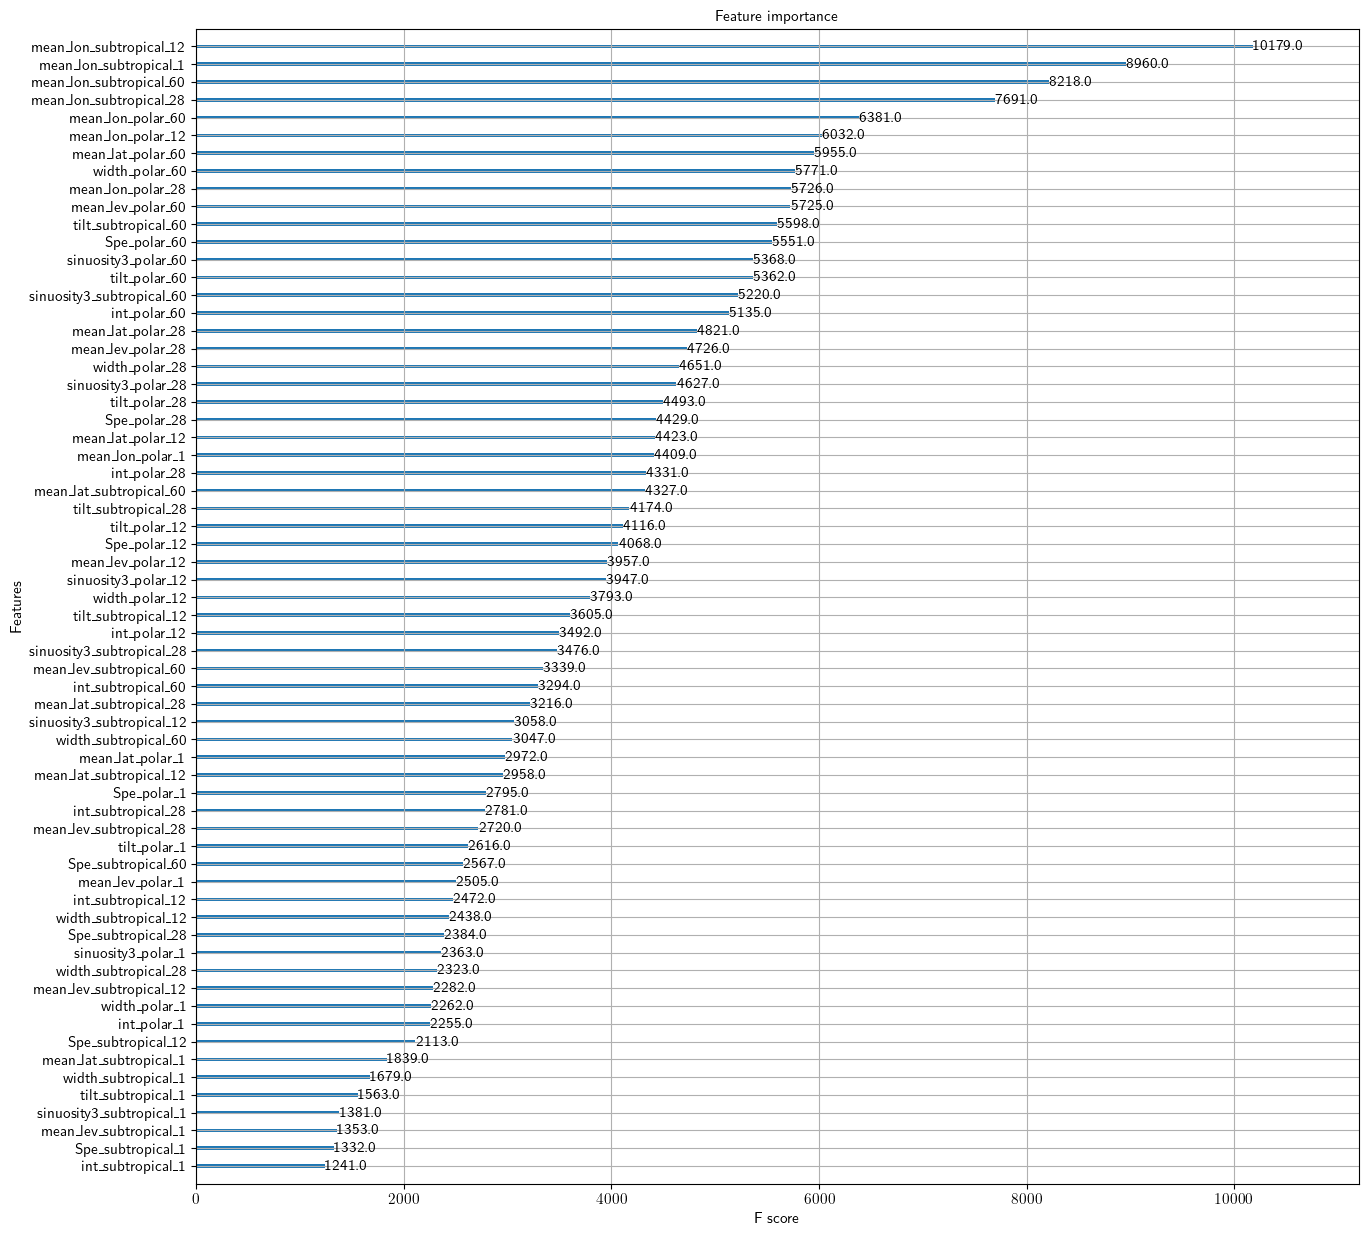

In [10]:
fig, ax = plt.subplots(figsize=(15, 15))
xgboost.plot_importance(bst, ax=ax)


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

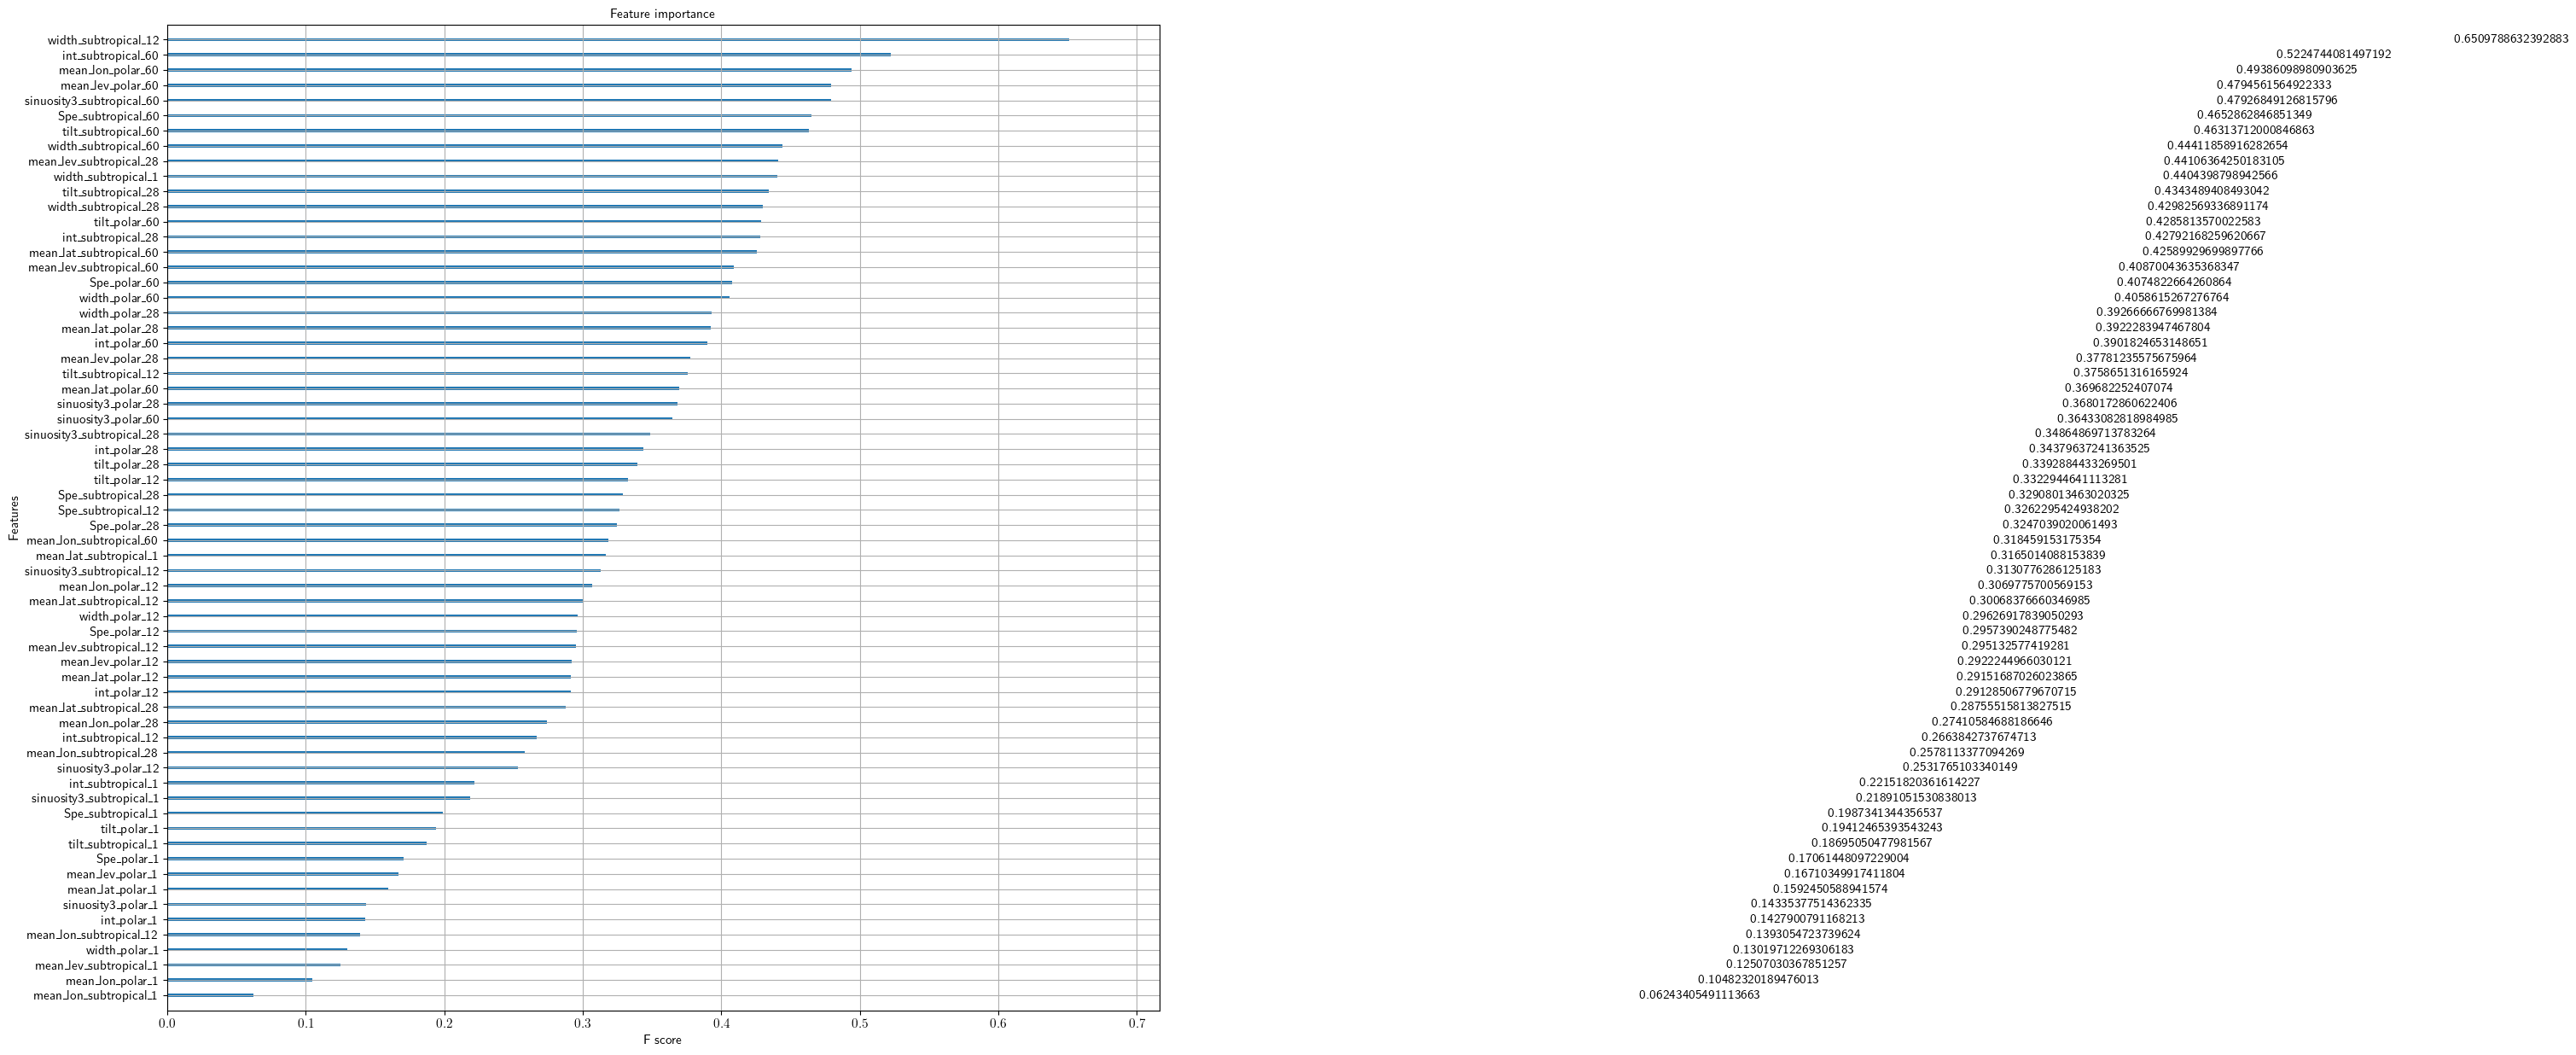

In [11]:
fig, ax = plt.subplots(figsize=(15, 15))
xgboost.plot_importance(bst, ax=ax, importance_type="gain")

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

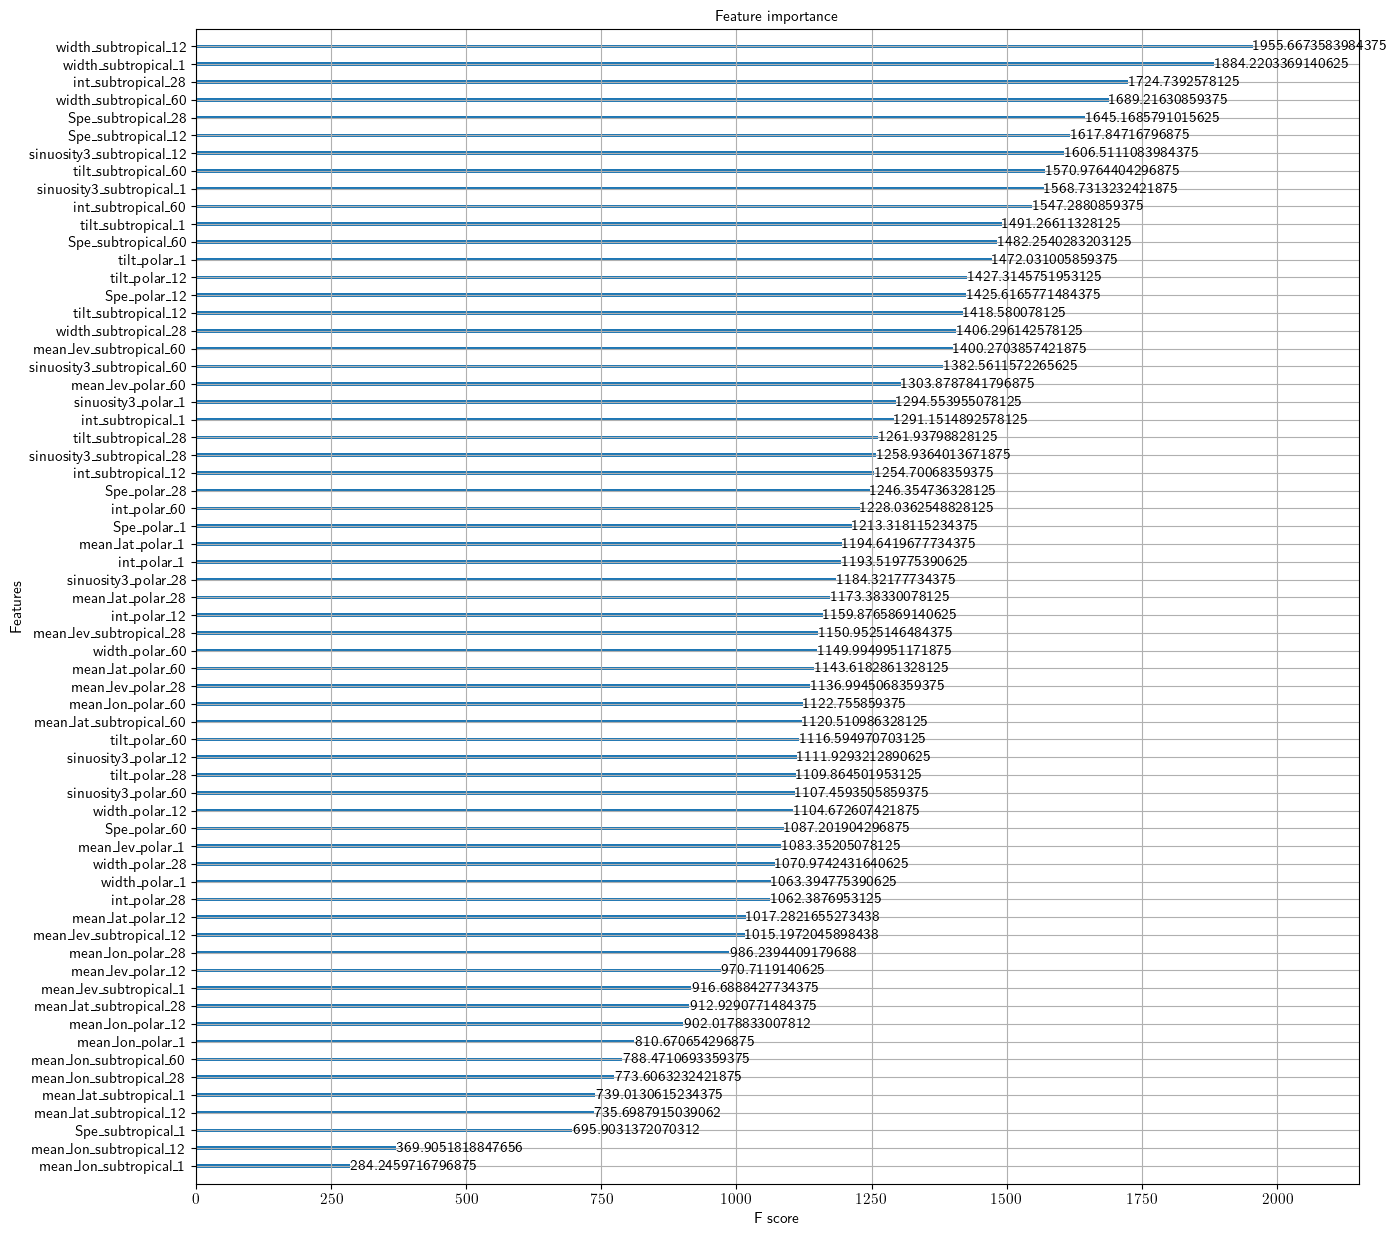

In [12]:
fig, ax = plt.subplots(figsize=(15, 15))
xgboost.plot_importance(bst, ax=ax, importance_type="cover")

In [21]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X, y)

In [35]:
shap.initjs()

In [60]:
shap.force_plot(0, shap_values[-100:], X.iloc[-100:], matplotlib=False)


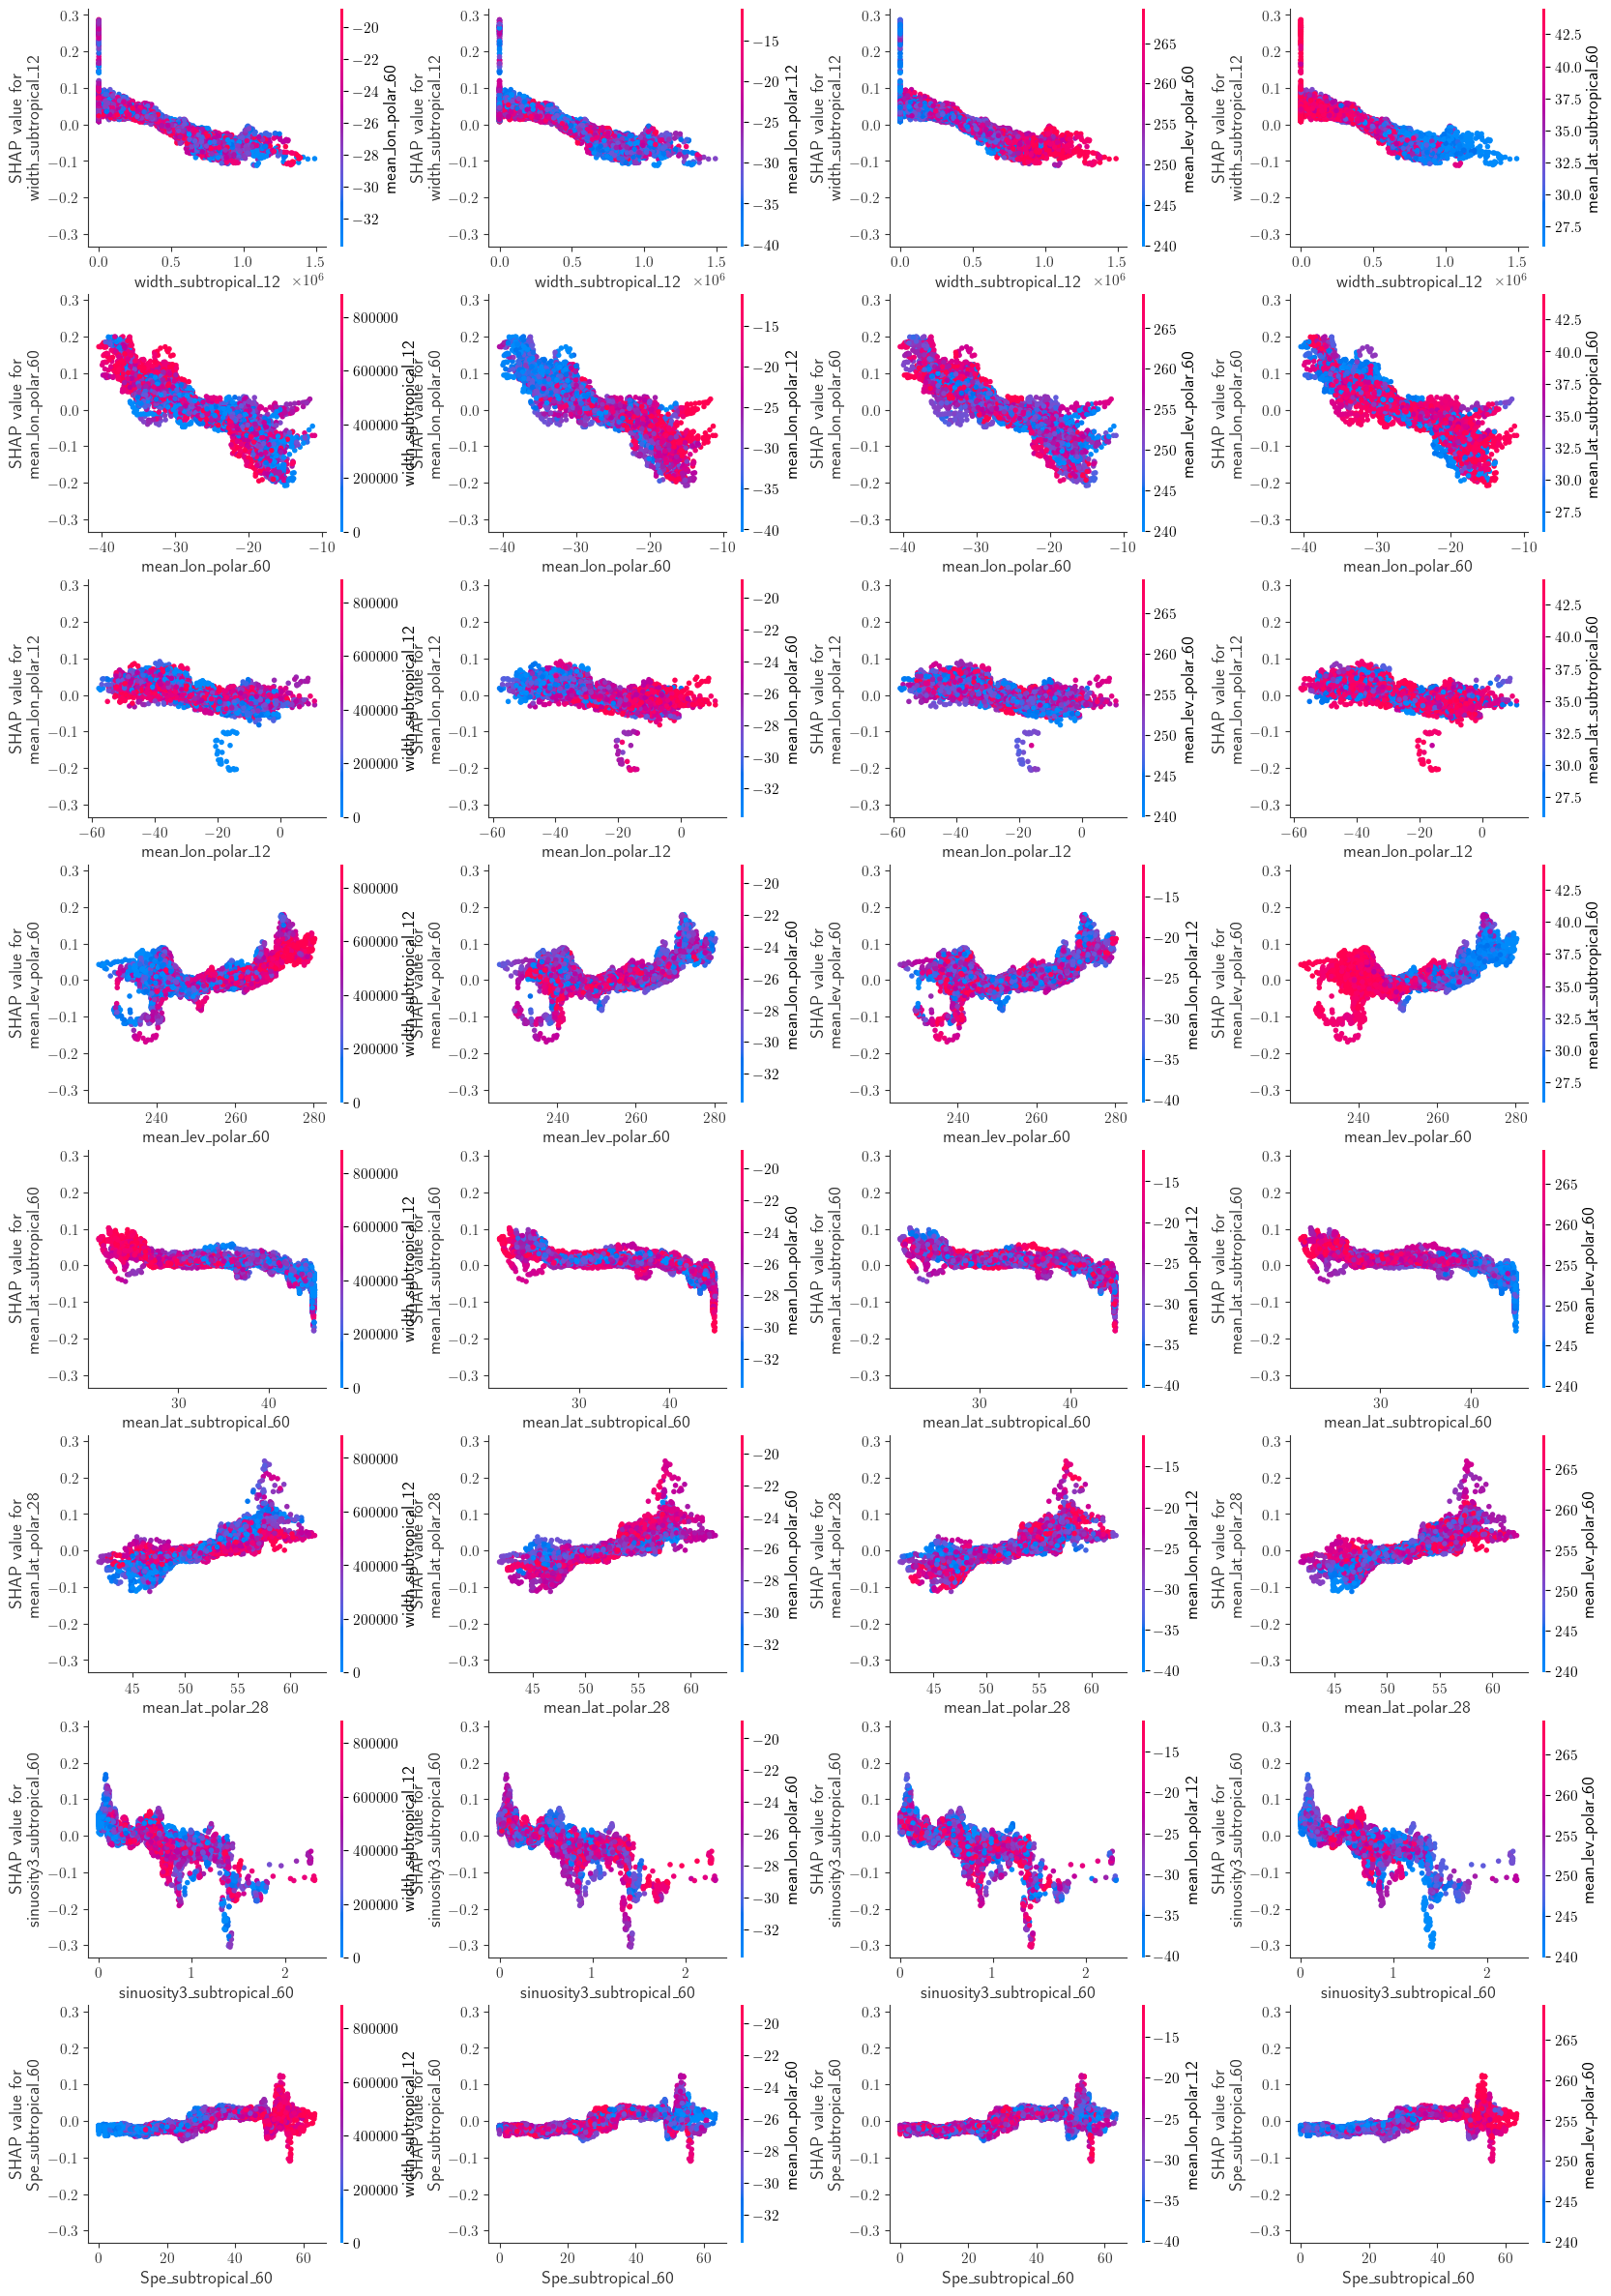

In [59]:
fig, axes = plt.subplots(8, 4, figsize=(20, 30), sharey="all", gridspec_kw={"wspace": 0.35})
for axs, rank in zip(axes, range(8)):
    otherranks = np.delete(np.arange(5), rank) if rank < 4 else np.arange(5)
    for ax, otherrank in zip(axs, otherranks):
        shap.dependence_plot(f"rank({rank})", shap_values, X, interaction_index=f"rank({otherrank})", ax=ax, show=False)
plt.show()